In [4]:
import sys
sys.path.insert(0,os.path.dirname(os.getcwd()))
import json
import pandas as pd
import sys 
from synthetic_scorers.RScore.RScore_calculation import interact_with_api
from synthetic_scorers.RSPred.predictorRS import RSPredictor
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def check_synth_score(benchmark_name):
    if "SAscore" in benchmark_name:
        synth_score="SAscore"
        benchmark_name = benchmark_name[:-7]
    elif "RScore" in benchmark_name:
        synth_score = "RScore"
        benchmark_name = benchmark_name[:-6]
    elif 'RSPred' in benchmark_name:
        synth_score="RSPred"
        benchmark_name = benchmark_name[:-6]
    else:
        synth_score="None"
    return synth_score, benchmark_name

In [5]:
def build_output():
    path_result = "../guacamol_baselines/smiles_lstm_hc/results/goal_directed_results_guacamol_paper.json"
    with open(path_result, "r") as f:
        results_json = json.load(f)["results"]
    results_df = pd.DataFrame(results_json)


    RScore_generation = pd.read_csv("../guacamol_baselines/smiles_lstm_hc/results/goal_hard_cws_results.csv")
    RScore_generation = RScore_generation[["smiles", "objective","spaya_score","property"]]

    top_100_per_bench = pd.DataFrame()

    for i, row in results_df.iterrows():
        results_bench = pd.DataFrame(data=row["optimized_molecules"], columns = ["smiles", "score"])
        synth_score, benchmark_name = check_synth_score(row["benchmark_name"])
        results_bench["benchmark"] = benchmark_name
        results_bench["synth_score"] = synth_score
        top_100_per_bench = pd.concat([top_100_per_bench, results_bench])

    top_100_rscore = RScore_generation[["smiles", "property","objective"]]
    top_100_rscore.columns = ["smiles", "benchmark","score"]
    top_100_rscore["synth_score"]="RScore"

    top_100_per_bench = pd.concat([top_100_per_bench, top_100_rscore]).reset_index(drop=True)
    predictorRS = RSPredictor()
    top_100_per_bench["RSPred"] = predictorRS.predict_many(top_100_per_bench.smiles.to_list())

    results = pd.DataFrame(interact_with_api(top_100_per_bench.smiles.to_list(), timeout=3))
    if len(results[results.status != "DONE"])>0:
        print("The molecules are not scored yet. Wait.")
    else:
        results = results[results.status=="DONE"]
        results = results[["smiles", "score"]]
        results.score = results.score.fillna(0)
        results = results.rename(columns={"score":"RScore_3mn"})
        top_100_per_bench_2 = top_100_per_bench.merge(results, on="smiles")
    return top_100_per_bench_2

In [7]:
if os.path.exists("results_data/results_guacamol_top_100_per_task.json"):
    print("File already exist")
    top_100_per_bench = pd.read_json("results_data/results_guacamol_top_100_per_task.json")

else:
    print("File don't exist, going to create it")
    top_100_per_bench = build_output()


File already exist


0.42851728859568095


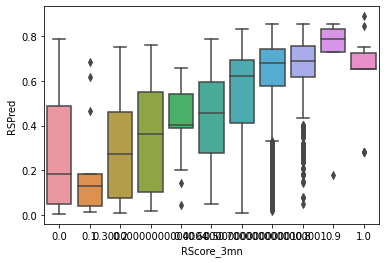

In [9]:
print(np.corrcoef(top_100_per_bench.RScore_3mn, top_100_per_bench.RSPred)[0,1])
_= sns.boxplot(x=top_100_per_bench.RScore_3mn, y= top_100_per_bench.RSPred)

In [10]:

def plot_change(synth, obj, x_labels, baseline, ax1=None, set_cbar=True, set_y1=False, y1_label="Objective", set_y2=False, 
                y2_label="Synthesizability", set_x=True, cbar_kw={}, cbarlabel="", font_size=8, set_title=True, title="", legend=False, **kwargs):
    
    x = np.array([1, 2, 3, 4])
    all_ys = [0, 0.5, 1]
    ax2 = ax1.twinx()
    ax1.plot(x, synth, color='green', marker='o', linestyle='-', linewidth=5, markersize=12, label = "% with RScore > 0.4")
    ax2.plot(x, obj, color='red', marker='o', linestyle='-', linewidth=5, markersize=12, label = "average reward")

    if legend :
        ax1.legend(bbox_to_anchor=(1,-0.2),fontsize=30, )
        ax2.legend(bbox_to_anchor=(1,-0.5),fontsize=30,)

    ax1.set_xlim(0.7, 4.3)
    ax1.set_xticks([1, 2, 3, 4])
    ax1.set_xticklabels(x_labels)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_yticks(np.array(all_ys))
    if set_y1:
        ax1.set_ylabel(y1_label, size=font_size)
    ax1.yaxis.tick_left()
    ax1.yaxis.set_label_position("left")
    ax1.yaxis.set_tick_params(color='red')

    ax2.set_ylim(-0.1, 1.1)
    ax2.set_yticks(np.array(all_ys))
    if set_y2:
        ax2.set_ylabel(y2_label, size=font_size)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

    ax1.grid(axis='y')

    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    ax1.spines['left'].set_color('red')
    ax2.spines['left'].set_color('red')
    ax1.spines['left'].set_linewidth(5)
    ax2.spines['left'].set_linewidth(5)

    ax1.spines['right'].set_color('green')
    ax2.spines['right'].set_color('green')
    ax1.spines['right'].set_linewidth(5)
    ax2.spines['right'].set_linewidth(5)

    ax1.spines['bottom'].set_linewidth(5)
    ax2.spines['bottom'].set_linewidth(5)

    plt.setp(ax1.get_xticklabels(), rotation=15, ha="center", rotation_mode="default")

    if set_x:
        ax1.tick_params(labelbottom=True, labelsize=font_size)
    else:
        ax1.tick_params(labelbottom=False, labelsize=font_size)
    ax2.tick_params(labelsize=font_size)

    if set_title:
        ax1.set_title(title, size=font_size)

    return None


In [11]:
objectives = ['Ranolazine MPO', 'Perindopril MPO', 'Valsartan SMARTS',
       'Deco Hop', 'Scaffold Hop', 'Osimertinib MPO', 'Fexofenadine MPO',
       'Amlodipine MPO', 'Sitagliptin MPO', 'Zaleplon MPO']

In [27]:
objectives.sort()

In [28]:
objectives

['Amlodipine MPO',
 'Deco Hop',
 'Fexofenadine MPO',
 'Osimertinib MPO',
 'Perindopril MPO',
 'Ranolazine MPO',
 'Scaffold Hop',
 'Sitagliptin MPO',
 'Valsartan SMARTS',
 'Zaleplon MPO']

In [12]:
top_100_per_bench["GoodRScore_3mn"]=top_100_per_bench.RScore_3mn.apply(lambda x : x>0.4)
top_100_per_bench["GoodRSPred"]=top_100_per_bench.RSPred.apply(lambda x : x>0.4)

In [13]:
results_per_bench = top_100_per_bench.groupby(by=["benchmark", "synth_score"]).mean()

In [31]:
top_100_per_bench[top_100_per_bench.synth_score=="None"].groupby(by="benchmark").mean()[["score","RScore_3mn", "GoodRScore_3mn"]]

,score,RScore_3mn,GoodRScore_3mn
benchmark,,,
Amlodipine MPO,0.863139,0.554000,0.770000
Deco Hop,0.986140,0.664463,0.966942
Fexofenadine MPO,0.888718,0.661864,0.949153
Osimertinib MPO,0.889230,0.506000,0.740000
Perindopril MPO,0.726177,0.588073,0.935780
Ranolazine MPO,0.796782,0.393000,0.500000
Scaffold Hop,0.544806,0.584286,0.814286
Sitagliptin MPO,0.441833,0.609231,0.825641
Valsartan SMARTS,0.775915,0.620870,0.895652


RED : reward of top 100
GREEN : rate with RScore >=0.5


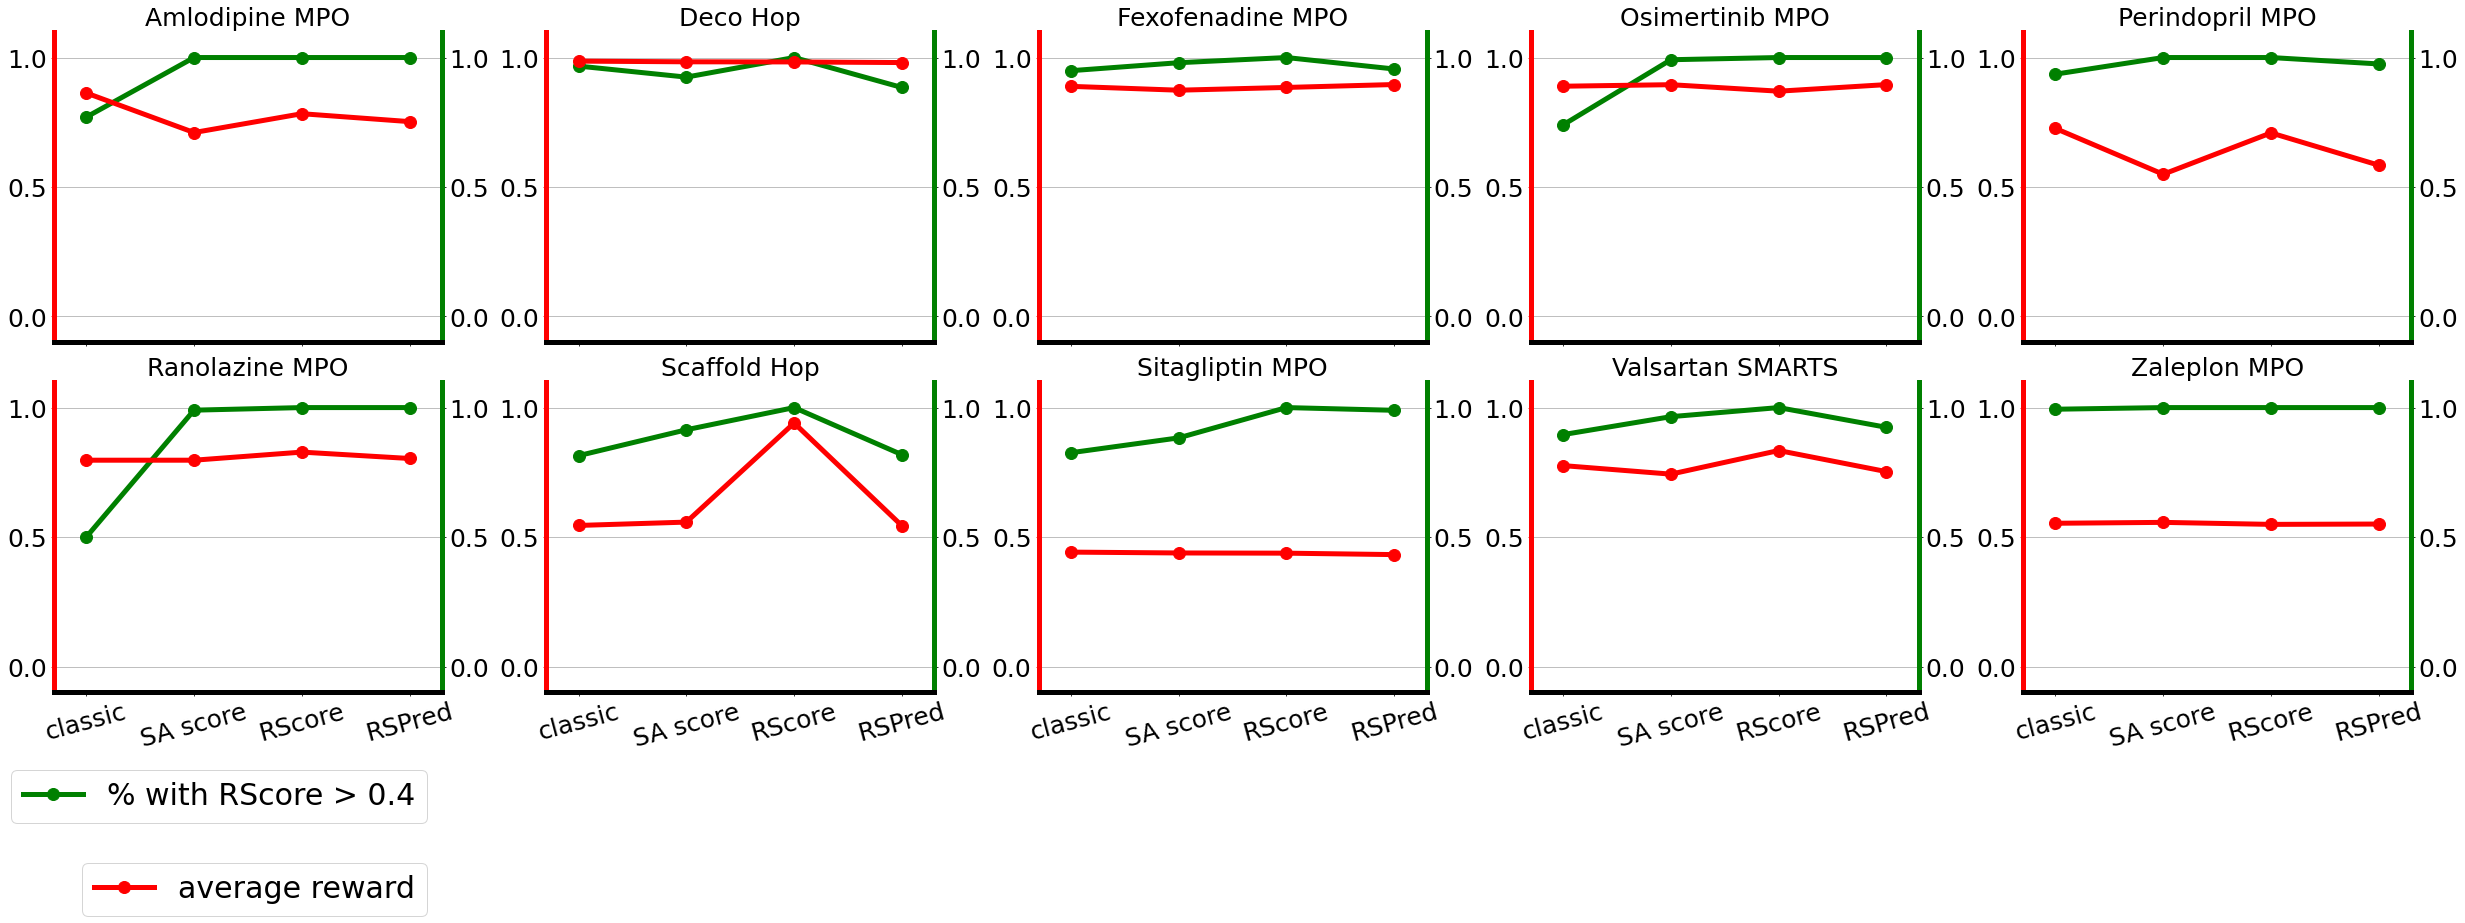

In [29]:
fig, ((ax1, ax2, ax3, ax4, ax5) , (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(35, 13))
min_spaya = 0
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
i=0
x_labels = ["classic", "SA score", "RScore",  "RSPred",]
for obj in objectives:
    classic_gen = results_per_bench.loc[(obj, "None")]
    SA_gen = results_per_bench.loc[(obj, "SAscore")]
    RSPred_gen = results_per_bench.loc[(obj,"RSPred")]
    RScore_gen = results_per_bench.loc[(obj, "RScore")]
    col = "GoodRScore_3mn"
    evo_good_RScore =  [classic_gen[col], SA_gen[col], RScore_gen[col], RSPred_gen[col]]
    
    col = "score"
    evo_reward = [classic_gen[col], SA_gen[col], RScore_gen[col], RSPred_gen[col]]
    

    set_x=False
    if i>=5:
        set_x=True
    plot_change(evo_good_RScore, evo_reward,  x_labels, baseline = 0.763, ax1=axs[i],  set_x=set_x, font_size=25, title=obj, legend=(i==5))
    i+=1

print("RED : reward of top 100")
print("GREEN : rate with RScore >=0.5")

plt.tight_layout()
plt.savefig("results_data/guacamol_experiment_plots.png")
plt.show()